In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Simulation with dynamo midpath ensemble as training image where SV hits training image variance"
nb_name = "nb_seqsim_core_sh30_newTI_svvar"

# Core

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

core.generate_map(target_var_factor = 1)

In [3]:
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9

core.ensemble_B(g_core_ens, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
m_core_ens = core.B_ensemble[:,0,:].copy()

In [10]:
np.var(m_core_ens,axis=0).shape

(687,)

<IPython.core.display.Javascript object>


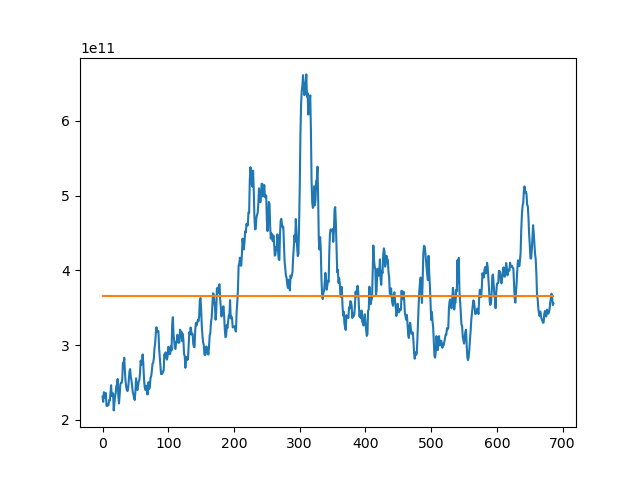

In [12]:
var_core_ens = np.var(m_core_ens,axis=0)

plt.figure()
plt.plot(var_core_ens)
plt.plot(np.ones(var_core_ens.shape)*np.mean(var_core_ens))
plt.show()

In [43]:
idx_close_to_var = np.argwhere(np.logical_and(var_core_ens>0.9970*np.mean(var_core_ens), var_core_ens<1.0030*np.mean(var_core_ens)))

In [44]:
idx_close_to_var

array([[386],
       [416]])

<IPython.core.display.Javascript object>


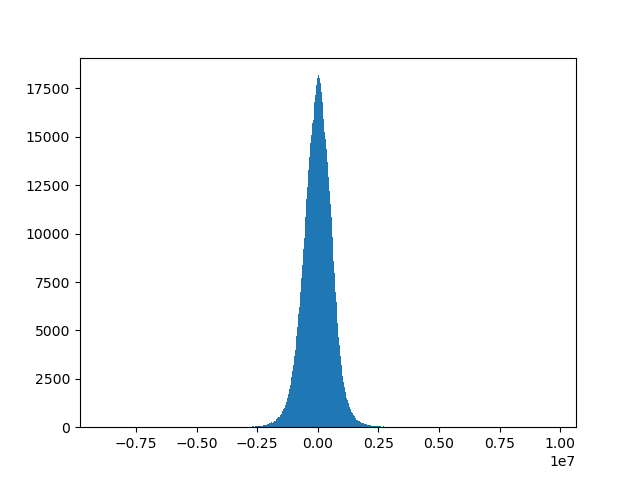

<IPython.core.display.Javascript object>


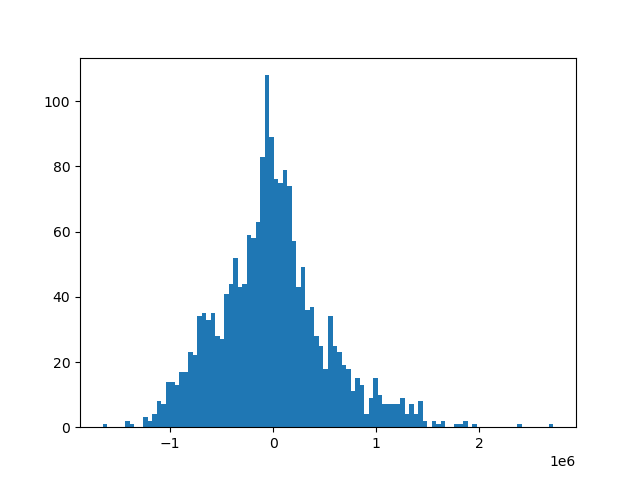

In [17]:
plt.figure()
plt.hist(np.ravel(m_core_ens),bins=1000)
plt.show()

plt.figure()
plt.hist(core.data,bins=100)
plt.show()

In [3]:
core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101) #model_hist = "ensemble"

In [6]:
core.semivar(model_lags = 8, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = True)

#keep_sv_curve = core.sv_curve.copy()
#keep_lags_sv_curve = core.lags_sv_curve.copy()

C_e_const = 2.0

#nugget = C_e_const**2
#nugget_p = 0.01
#var_fac = 0.1

#set_model = {"a": 2000, "C0": var_fac*core.target_var*nugget_p, "C1": var_fac*core.target_var*(1-nugget_p), "C2": None, "C3": None}
#set_model = {"a": 1800, "C0": nugget, "C1": var_fac*core.target_var-nugget, "C2": None, "C3": None}

#set_model = {"a": 1700, "C0": 0.0, "C1": core.target_var, "C2": None, "C3": None}


#set_model = {"a": 200, "C0": 0.0, "C1": 0.15*core.target_var,
#             "C2": core.target_var-0.15*core.target_var, "C3": 20000}


#core.semivar(model_lags = "all", model = "dub_spherical", max_dist = 20000, lag_length = 200,
#             zero_nugget = True, hit_target_var = True, set_model = set_model)

#core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
#             zero_nugget = True, hit_target_var = True, set_model = set_model)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 8

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


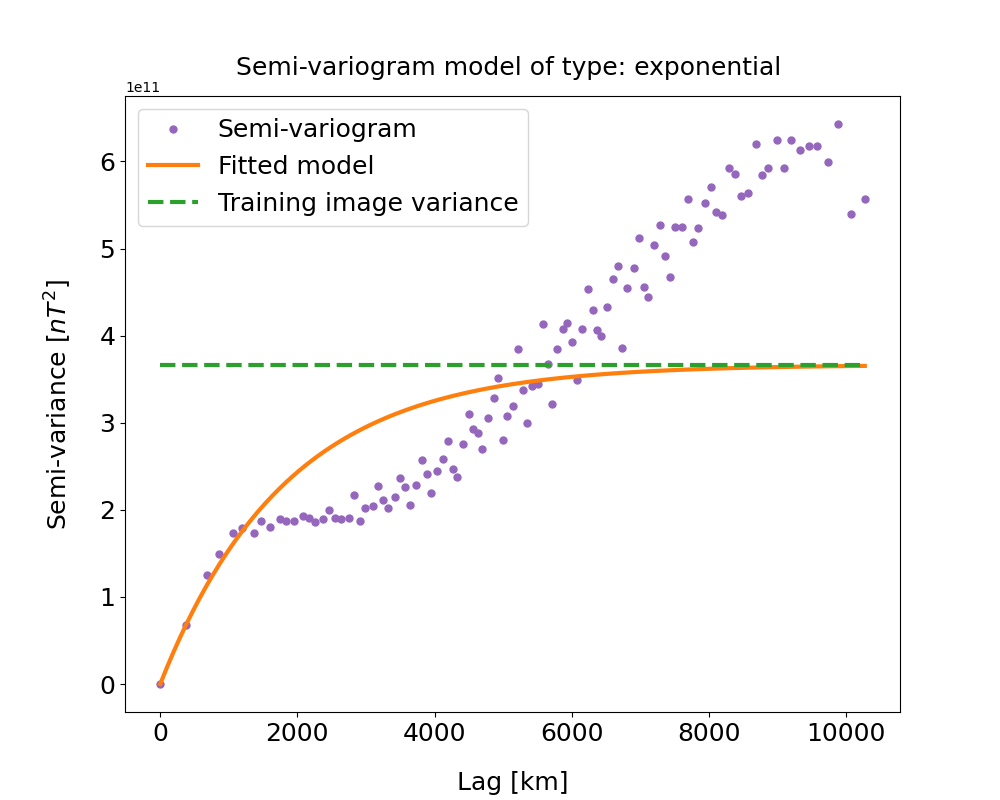

In [7]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1', linewidth = 3,label='Fitted model')
#plt.plot(keep_lags_sv_curve,keep_sv_curve,"--",color='C0',linewidth = 3,label='Fitted model')

plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3,
         color="C2", linestyle="dashed", label="Training image variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [6]:
#print(core)

# Synthetic sat

In [8]:
s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)

In [9]:
s_sat.generate_map(grid_type = "swarm")

In [10]:
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [11]:
#mt_util.plot_cartopy_global(lat = s_sat.lat, lon = s_sat.lon, plot_quality = "high", point_size=5, 
#                            data=s_sat.data, cmap = 'PuOr_r', title="Synthetic satellite data")

In [12]:
#print(s_sat)

# Source truth

In [13]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [14]:
core.integrating_kernel(s_sat, C_e_const = C_e_const)

# SDSSIM

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.662 minutes 
Total elapsed time: 8.662 minutes 
Variance: 271902638928.262
Mean: -6313.809
Max: 1750338.604
Min: -1524645.609
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.726 minutes 
Total elapsed time: 17.388 minutes 
Variance: 267969050201.808
Mean: -14616.208
Max: 2225501.236
Min: -1330491.081
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.692 minutes 
Total elapsed time: 26.080 minutes 
Variance: 268580956687.583
Mean: -11890.442
Max: 2006857.014
Min: -1275646.596
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.729 minutes 
Total elapsed time: 34.809 minutes 
Variance: 268302823365.274
Mean: -10437.735
Max: 1646957.291
Min: -1719711.238
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realiza

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 9.034 minutes 
Total elapsed time: 4.962 hours 
Variance: 273000061912.275
Mean: -11206.527
Max: 1768251.848
Min: -1600158.374
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 9.543 minutes 
Total elapsed time: 5.121 hours 
Variance: 265977138009.304
Mean: -13257.544
Max: 1629116.813
Min: -1304689.022
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.736 minutes 
Total elapsed time: 5.267 hours 
Variance: 272040535866.151
Mean: -9809.698
Max: 1821754.519
Min: -1546353.567
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.063 minutes 
Total elapsed time: 5.401 hours 
Variance: 271019574531.486
Mean: -8966.366
Max: 1658033.821
Min: -1273854.605
Run nr.: 38

 |OOOOOOOOOO| 100.0%   realization

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.291 minutes 
Total elapsed time: 10.514 hours 
Variance: 269333749082.987
Mean: -9876.941
Max: 1842910.423
Min: -1320885.130
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.312 minutes 
Total elapsed time: 10.653 hours 
Variance: 268853062254.482
Mean: -6443.236
Max: 1722222.895
Min: -1587159.401
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.279 minutes 
Total elapsed time: 10.791 hours 
Variance: 277878290451.220
Mean: -11650.500
Max: 1577777.547
Min: -1434117.884
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.4
Run time: 8.454 minutes 
Total elapsed time: 10.931 hours 
Variance: 277520001929.639
Mean: -9562.684
Max: 1776305.640
Min: -2691984.281
Run nr.: 72

 |OOOOOOOOOO| 100.0%   realizat

<IPython.core.display.Javascript object>


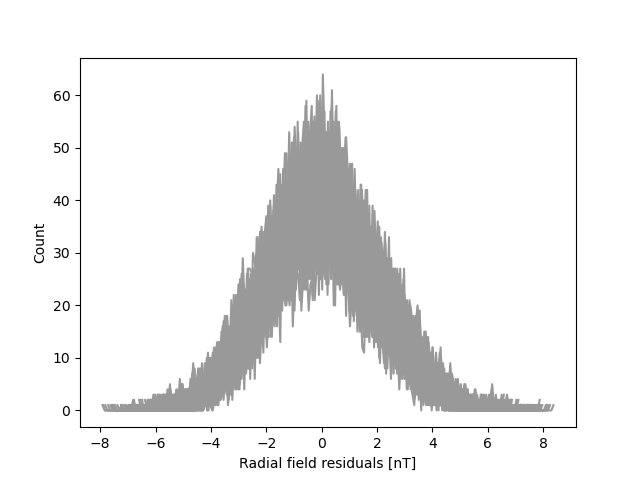

In [22]:
N_sim = 100

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

In [23]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_g)

In [24]:
core.covmod_lsq_equiv(s_sat.data, core.C_mm_all, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


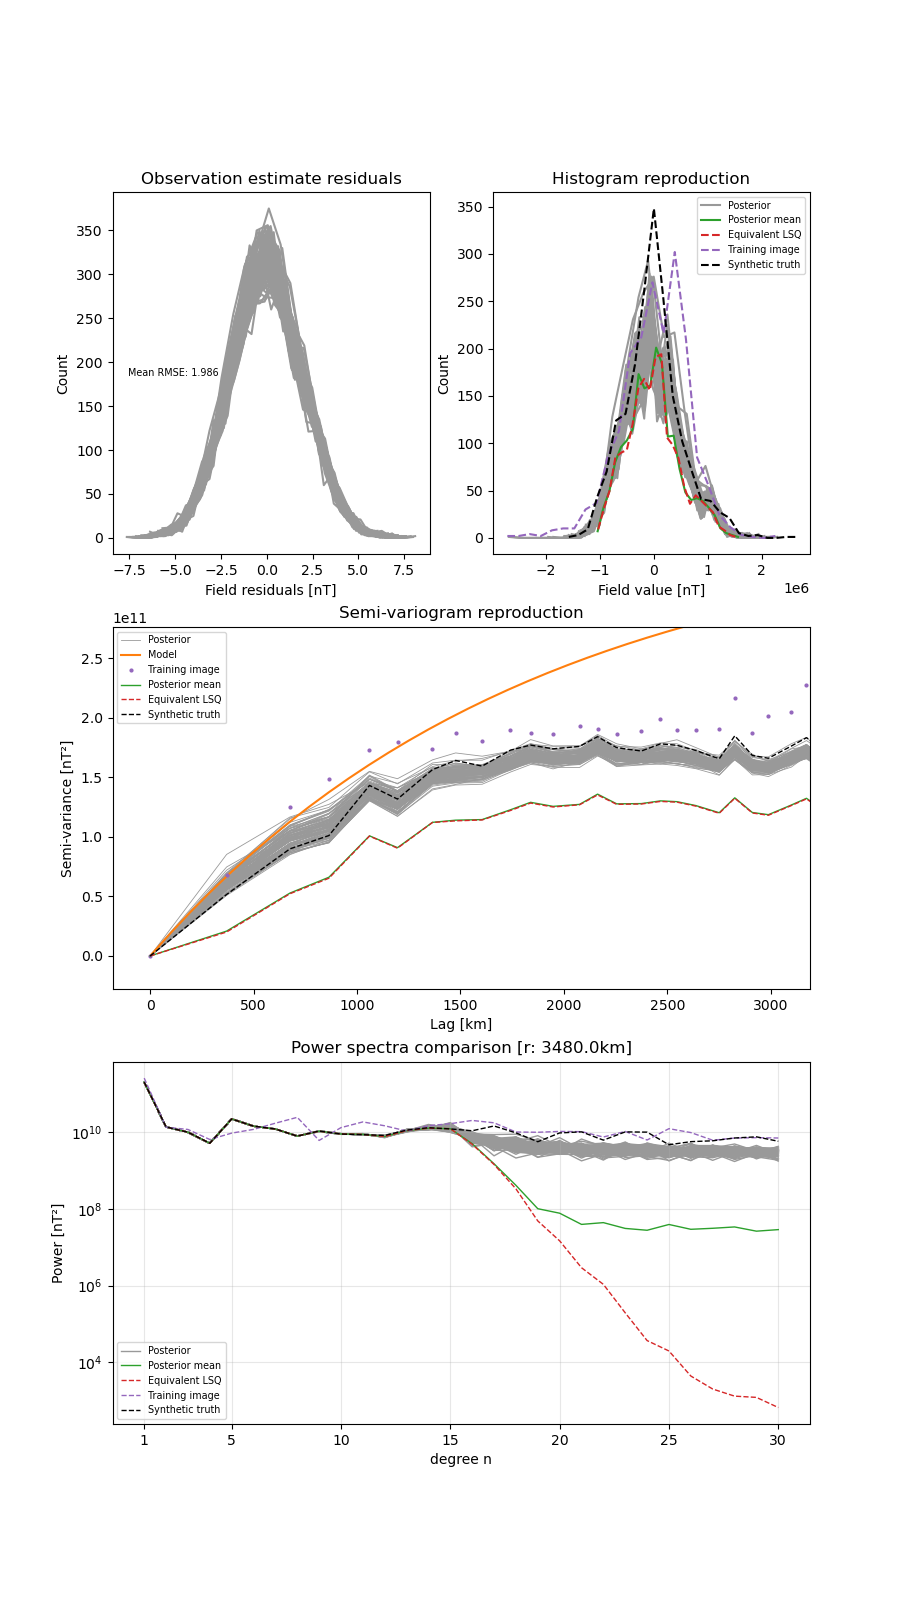

In [25]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 25, res_bins = 25,
                              savefig = False, save_string = "core_sh30_newTI_svvar", save_dpi = 300)

In [26]:
skip = 1

m_skip = core.m_DSS[:,:][0::skip]

lat_skip = core.lat[0::skip]

lon_skip = core.lon[0::skip]

In [27]:
N_bins = 20
m_centers = []
m_y = []

for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_skip[i,:],bins=N_bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    m_centers.append(bincenters)
    m_y.append(y)
    
m_centers = np.array(m_centers)
m_y = np.array(m_y)

In [28]:
deg_range = 1

lat_skip_lin = np.linspace(lat_skip-deg_range,lat_skip+deg_range,N_bins)
lon_skip_lin = np.linspace(lon_skip-2*deg_range,lon_skip+2*deg_range,N_bins)

In [29]:
m_y_scaled = []

for i in np.arange(0,m_skip.shape[0]):
    scale = np.min(lat_skip_lin[:,i]) + (m_y[i,:]-np.min(m_y[i,:]))*(np.max(lat_skip_lin[:,i])-np.min(lat_skip_lin[:,i]))/(np.max(m_y[i,:])-np.min(m_y[i,:]))

    m_y_scaled.append(scale)
    
m_y_scaled = np.array(m_y_scaled)

In [30]:
local_lat = m_y_scaled.reshape(-1,)

local_lon = lon_skip_lin.T.reshape(-1,)

local_data = m_centers.reshape(-1,)

<IPython.core.display.Javascript object>


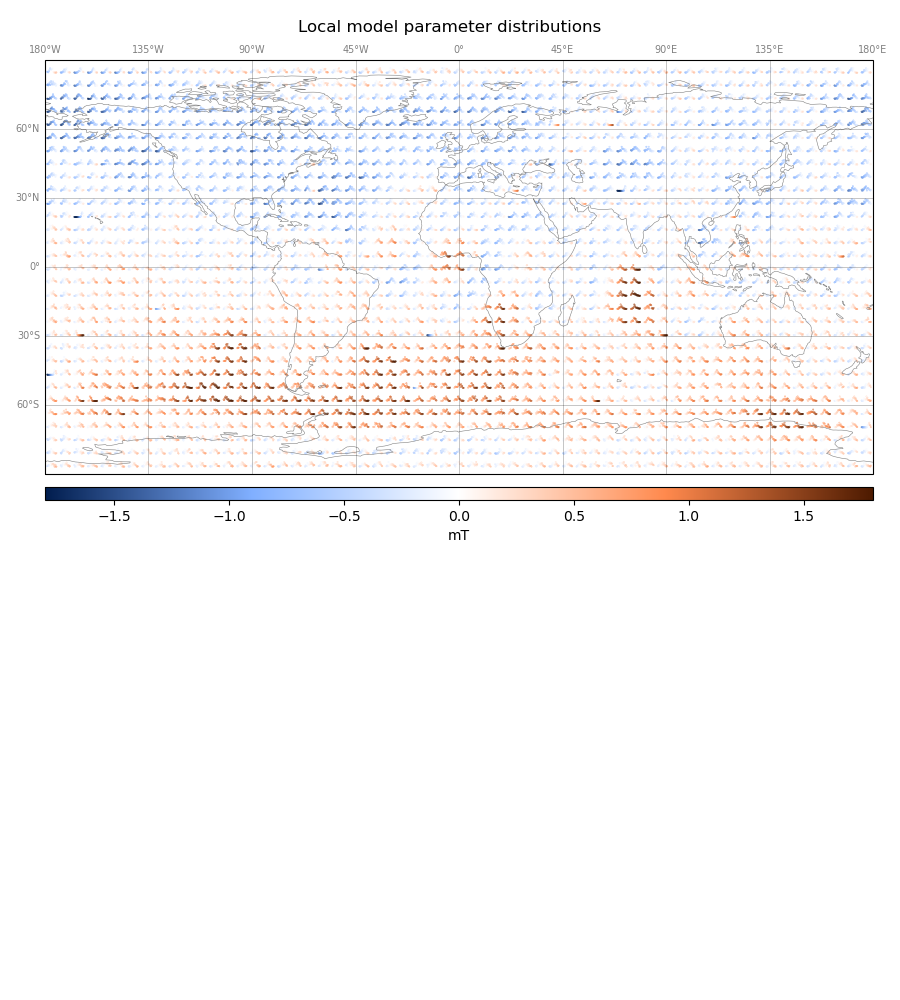

In [31]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)



mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, 
                cbar_h = 0.03, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(9,10), coast_width = 0.4,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.05,
                title='Local model parameter distributions', point_size=0.1, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string ="core_sh30_newTI_svvar_loc_mod_dist",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [32]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_g

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


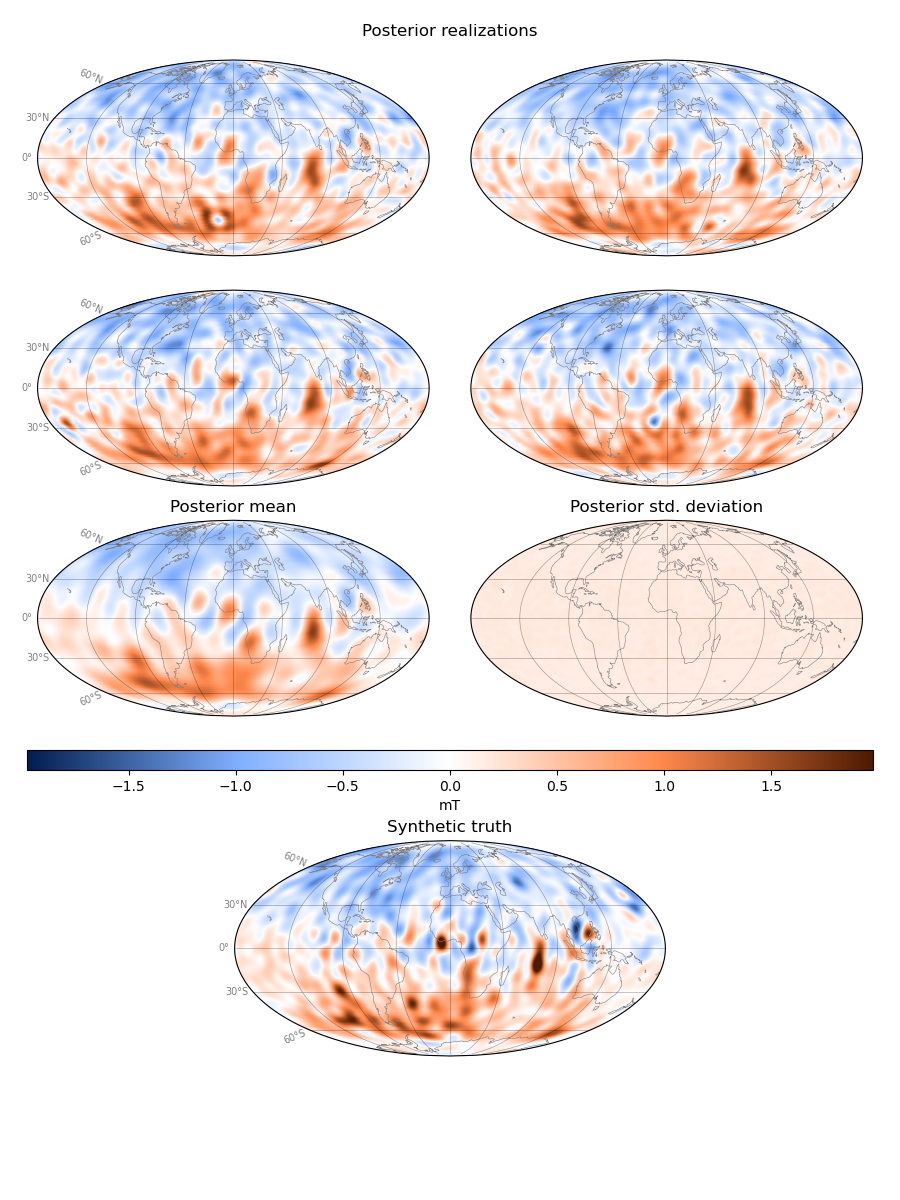

In [33]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI_svvar", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


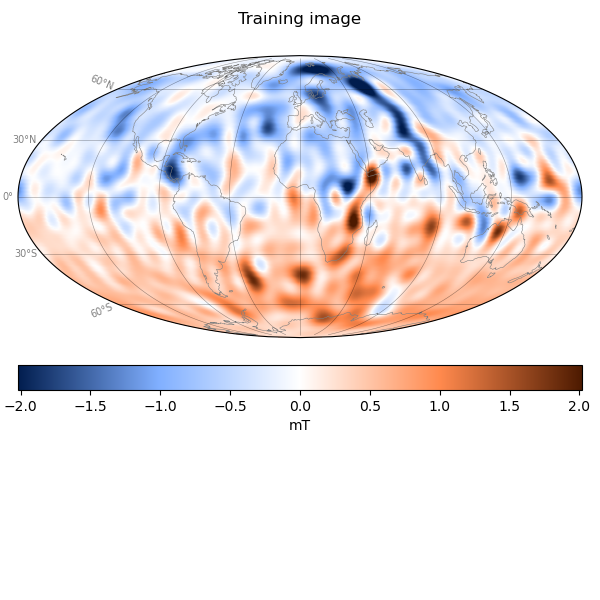

In [21]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="core_sh30_synth_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [23]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")